# Trénovanie modelu iba na základe DST indexu 1 h dopredu 3 h dozadu
Súbor: 1_dopredu_3_dozadu.ipynb

Program: Hospodárska informatika

Vypracovala: Veronika Motúzová

Diplomová práca: : Predikcia geomagnetickych búrok pomocou hlbokého učenia

Vedúci diplomovej práce: doc. Ing. Peter Butka, PhD.

Konzultanti: Ing. Viera Maslej Krešňáková, RNDr. Šimon Mackovjak, PhD. 

### Inštalácia knižníc

In [ ]:
!pip install pyarrow
!pip install keras
!pip install --upgrade tensorflow
!pip install --upgrade tensorflow-gpu

### Kontrola kapacity servera

In [ ]:
!nvidia-smi

### Import knižníc

In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential

from keras.layers import Dense, Activation, Dropout, Input, Conv1D, LSTM, MaxPooling1D, Flatten, TimeDistributed, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model


from scipy.special import expit, logit

from sklearn.metrics import confusion_matrix, classification_report

### Načitanie dát, odstránenie na hodnôt, určenie predikovaného atribútu

In [2]:
df = pd.read_csv('omni_full.csv')
len(df)

520443

In [ ]:
df.columns

In [4]:
features = ['time1',
            'DST']

In [5]:
df = df[features]

In [7]:
df['time1']=pd.to_datetime(df['time1'])

In [8]:
df.dropna(inplace=True)
print(len(df))

520443


In [9]:
predicted_label = 'DST'

In [10]:
df.describe()

,DST
count,520443.000000
mean,-14.125015
std,22.034833
min,-589.000000
25%,-22.000000
50%,-10.000000
75%,-1.000000
max,81.000000


In [ ]:
df[predicted_label].describe()

In [ ]:
df.head()

In [ ]:
df[predicted_label].hist(bins=100)

In [ ]:
# transform label using sigmoid
variance = df[predicted_label].std()
df["contcontinuous_transforminuous_transform"] = df[predicted_label].apply(lambda x: expit(2 * ((x - 0.2) / variance)))
df["contcontinuous_transforminuous_transform"].describe()

In [11]:
# choose one of them
# define y variable, i.e., what we want to predict

y_col='DST'
#y_col='contcontinuous_transforminuous_transform'

In [12]:
# train-test division

test_size = int(len(df) * 0.2) # here I ask that the test data will be 20% of the entire data
train = df.iloc[:-test_size,:].copy()
test = df.iloc[-test_size:,:].copy()

In [13]:
# train-validation division

valid_size = int(len(train) * 0.2) # here I ask that the test data will be 15% of the entire data
valid = train.iloc[-valid_size:,:].copy()
train = train.iloc[:-valid_size,:].copy()

In [14]:
# separate features and labels

y_train = train[y_col].values.copy()
X_train = train[y_col].values.copy()

y_val = valid[y_col].values.copy()
X_val = valid[y_col].values.copy()

y_test = test[y_col].values.copy()
X_test = test[y_col].values.copy()

In [ ]:
print(y_test[0:40])

In [16]:
len(y_test)

104088

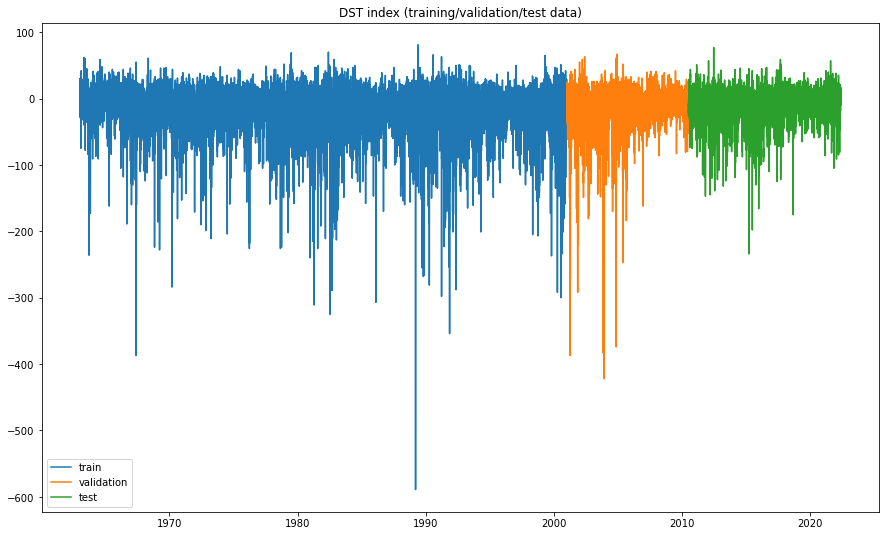

In [17]:
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
%matplotlib inline
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [15, 9]
plt.figure()
plt.title("DST index (training/validation/test data)")
plt.plot(train['time1'],train['DST'],label='train')
plt.plot(valid['time1'],valid['DST'],label='validation')
plt.plot(test['time1'],test['DST'],label='test')
plt.legend();

In [18]:
# set batch, n_input, n_features

n_input = 3  # how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= len(X_train)  # how many predictors/Xs/features we have to predict y
b_size = 256  # Number of timeseries samples in each batch

train_generator = TimeseriesGenerator(X_train, y_train, length=n_input, batch_size=b_size)
val_generator = TimeseriesGenerator(X_val, y_val, length=n_input, batch_size=b_size)
test_generator = TimeseriesGenerator(X_test, y_test, length=n_input, batch_size=256)

In [ ]:
for i in range(len(test_generator)):
	x, y = test_generator[i]
	print('tt %s => %s' % (x, y))

In [20]:
print("Počet batchov: ", len(train_generator))
print("Každý batch má features (X zložku) a labels (y zložku): ", len(train_generator[0]))
print("Dĺžka X zložky batchu: ", len(train_generator[0][0]))
print("Dĺžka y zložky batchu (počet meraní v batchi): ",len(train_generator[0][1]))
print("Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu): ", len(train_generator[0][0][0]))

Počet batchov:  1302
Každý batch má features (X zložku) a labels (y zložku):  2
Dĺžka X zložky batchu:  256
Dĺžka y zložky batchu (počet meraní v batchi):  256
Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu):  3


In [21]:
inputs = Input(shape=(n_input,1))
b = Conv1D(128, kernel_size = 4, padding = "same")(inputs)
b = Bidirectional(LSTM(128, dropout=0.1,recurrent_dropout=0.1))(inputs)
b = Dense(64, activation='relu')(b)
b = Dropout(0.2)(b)
x = Dense(32, activation='relu')(b)
output = Dense(1, activation='linear')(x)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='mse', optimizer='adam', metrics=["mae"])
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3, 1)]            0         
                                                                 
 bidirectional (Bidirectiona  (None, 256)              133120    
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                             

In [25]:
inputs = Input(shape=(n_input,1))
c = Bidirectional(LSTM(128, return_sequences=True, dropout=0.1,recurrent_dropout=0.1))(inputs)
c = LSTM(128, return_sequences=True)(c)
c = TimeDistributed(Dense(1, activation='linear'))(c)
output = Flatten()(c)
output = Dense(1, activation='linear')(output)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='mse', optimizer='adam', metrics=["mae"])
print(model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 3, 1)]            0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 3, 256)           133120    
 nal)                                                            
                                                                 
 lstm_4 (LSTM)               (None, 3, 128)            197120    
                                                                 
 time_distributed_1 (TimeDis  (None, 3, 1)             129       
 tributed)                                                       
                                                                 
 flatten_1 (Flatten)         (None, 3)                 0         
                                                                 
 dense_6 (Dense)             (None, 1)                 4   

In [26]:
# callbacks
saved_model = "model_2.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_mae', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_mae", mode="min", patience=25)
callbacks_list = [checkpoint, early]

In [27]:
# fit
history = model.fit(train_generator, validation_data=val_generator, epochs=10, verbose=1, callbacks = callbacks_list)

Epoch 1/10
1300/1302 [============================>.] - ETA: 0s - loss: 146.5151 - mae: 5.3156
Epoch 1: val_mae improved from inf to 3.88137, saving model to model_2.hdf5
1302/1302 [==============================] - 37s 24ms/step - loss: 146.3207 - mae: 5.3124 - val_loss: 78.4242 - val_mae: 3.8814
Epoch 2/10
1302/1302 [==============================] - ETA: 0s - loss: 42.2645 - mae: 3.3962
Epoch 2: val_mae improved from 3.88137 to 2.94730, saving model to model_2.hdf5
1302/1302 [==============================] - 31s 24ms/step - loss: 42.2645 - mae: 3.3962 - val_loss: 41.2813 - val_mae: 2.9473
Epoch 3/10
1302/1302 [==============================] - ETA: 0s - loss: 34.2251 - mae: 3.2844
Epoch 3: val_mae did not improve from 2.94730
1302/1302 [==============================] - 31s 24ms/step - loss: 34.2251 - mae: 3.2844 - val_loss: 35.5514 - val_mae: 2.9634
Epoch 4/10
1301/1302 [============================>.] - ETA: 0s - loss: 28.5542 - mae: 3.2091
Epoch 4: val_mae did not improve from 2

In [28]:
# load best model
model = keras.models.load_model('model_2.hdf5')

In [29]:
# prediction
y_pred = model.predict(test_generator)

407/407 [==============================] - 5s 10ms/step


In [ ]:
y_pred

In [31]:
# confusion matrix
# TN FP
# FN TP

y_pred2 = np.where(y_pred <= -20, 1, 0)
# [n_input:] because prediction starts from n-th row
y_test2 = np.where(y_test[n_input:]  <= -20, 1, 0)

cm = confusion_matrix(y_test2, y_pred2)
print("Confusion matrix: \n" + str(cm))

Confusion matrix: 
[[82273  1096]
 [ 2970 17746]]


In [32]:
print(classification_report(y_test2, y_pred2))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     83369
           1       0.94      0.86      0.90     20716

    accuracy                           0.96    104085
   macro avg       0.95      0.92      0.94    104085
weighted avg       0.96      0.96      0.96    104085



In [33]:
df = pd.DataFrame(data={"time": test['time1'][n_input:],"y_true": y_test[n_input:].reshape(-1) , "y_predict": y_pred.reshape(-1)})

In [34]:
df

,time,y_true,y_predict
416358,2010-06-29 08:00:00,-17.0,-11.681597
416359,2010-06-29 09:00:00,-17.0,-18.203098
416360,2010-06-29 10:00:00,-15.0,-15.433411
416361,2010-06-29 11:00:00,-11.0,-13.650112
416362,2010-06-29 12:00:00,-8.0,-9.506382
...,...,...,...
520438,2022-05-13 12:00:00,2.0,0.107270
520439,2022-05-13 13:00:00,4.0,1.844490
520440,2022-05-13 14:00:00,5.0,3.850308
520441,2022-05-13 15:00:00,5.0,3.924243


In [35]:
df.describe()

,y_true,y_predict
count,104085.000000,104085.000000
mean,-9.640928,-9.753717
std,16.039960,15.193985
min,-234.000000,-212.117798
25%,-17.000000,-16.011124
50%,-7.000000,-6.722116
75%,0.000000,-0.155047
max,77.000000,44.786690


In [ ]:
df["y_true"].hist(bins=100)

In [ ]:
df["y_predict"].hist(bins=100)

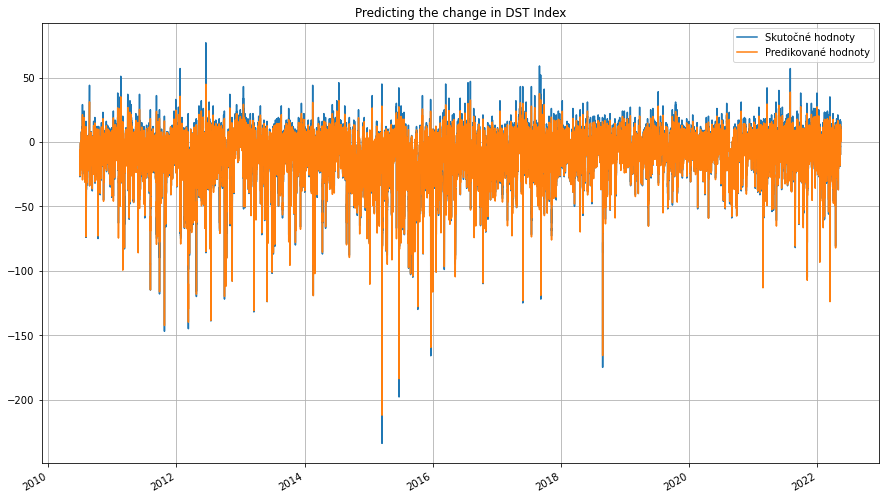

In [38]:
plt.figure()
plt.title('Predicting the change in DST Index')
plt.plot(df['time'],df['y_true'], label='Skutočné hodnoty')
plt.plot(df['time'],df['y_predict'], label='Predikované hodnoty')
plt.legend()
plt.gcf().autofmt_xdate()
plt.grid(True)

In [39]:
df.to_csv('predikcie_3h_dozadu_1h_dopredu.csv')